In [77]:
#Importing the librairies

import numpy as np
import matplotlib.pyplot as plt
import random
try:
    import importlib
    importlib.reload(h)
    importlib.reload(f)
    importlib.reload(d)
except NameError: # It hasn't been imported yet
    import helpers as h
    import implementations as f
    import data_processing as d

In [78]:
#We fix the random seed in order to get the same results ecery time we run the notebook
np.random.seed(1)

# Data preprocessing and feature selections

## Data preprocessing

To open the data, the data folder needs to be one level above the project folder and the data-dontaining folder needs to be named 'data'. The data folder should contain the following files:
- 'x_train.csv'
- 'y_train.csv'
- 'x_test.csv'

In [79]:
# x_train, x_test, y_train, train_ids, test_ids = h.load_csv_data("../data")

In [80]:
#Saving the generated arrays in .npy files in order to have faster access to them

#np.save('../data/y_train.npy', y_train)
#np.save('../data/x_train.npy', x_train)
#np.save('../data/x_test.npy', x_test)
#np.save('../data/train_ids.npy', train_ids)
#np.save('../data/test_ids.npy', test_ids)

In [81]:
#Loading the arrays from the .npy files

x_train = np.load("../data/x_train.npy")
x_test = np.load("../data/x_test.npy")
y_train = np.load("../data/y_train.npy")
train_ids = np.load("../data/train_ids.npy")
test_ids = np.load("../data/test_ids.npy")

In [82]:
#Generates the features names

features_name = np.genfromtxt('../data/x_train.csv', delimiter=',', dtype=str, max_rows=1)[1:] 

## Features selection

The original data contains 321 features, but the majority of them are not useful for the prediction. Therefore, we need to select the features that are useful for the prediction. The American Heart Association (AHA) identifies a range of risk factors for heart disease, including:
- Tobacco and alcohol use
- Physical inactivity
- Nutrution
- Obesity & overweight
- Blood cholesterol
- Diabetes
- Blood pressure

and some factors having an influence on the risk factors as : 
- Age
- Income 
- Education
- Gender
- Access and affordability of health care

To represent these factors, the following 21 features were selected:

- GENHLTH: General health condition
- MENTHLTH: Number of days with mental health not good
- PHYSHLTH: Number of days with physical health not good
- HLTHPLN1 : Health care coverage
- MEDCOST : Delayed medical treatment due to costs
- TOLDHI2 : High blood cholesterol
- CVDSTRK3 : Ever told you had a stroke
- DIABETE3 : Ever told you had diabetes
- SEX : Gender of the respondent
- EDUCA : Level of education
- INCOME2 : Annual household income
- DIFFWALK : Difficulty walking
- SMOKE100 : Smoked at least 100 cigarettes in life
- _RFHYPE5 : High blood pressure
- _CHOLCHK : Checked cholesterol within the last 5 years
- _AGEG5YR : Age group
- _BMI5 : Body mass index
- _TOTINDA : Physical activity
- _FRTLT1 : Fruit consumption
- _VEGLT1 : Vegetable consumption
- _RFDRHV5 : Heavy drinking



In [83]:
#Select the important features
features_list = ['_RFHYPE5', 'TOLDHI2', '_CHOLCHK', '_BMI5', 'SMOKE100', 'CVDSTRK3', 'DIABETE3', '_TOTINDA', '_FRTLT1', '_VEGLT1', '_RFDRHV5', 
                 'HLTHPLN1', 'MEDCOST', 'GENHLTH', 'MENTHLTH', 'PHYSHLTH', 'DIFFWALK', 'SEX', '_AGEG5YR', 'EDUCA', 'INCOME2', ]


In [84]:
#Create a mask for feature selection and apply it to the data

trainMask, testMask = f.masking((x_train, x_test), features_name, features_list)


## Processing
### We clean data for each chosen features, making them binary or trimming the values with no answer

In [85]:
#Train and test feature cleaning and processing

trainProcessed = d.feature_processing_test(trainMask)
testProcessed  = d.feature_processing_test(testMask)

#Replace missing values by the mean of the feature

x_train_algo = f.replaceMissingValuesMean(trainProcessed)
x_test_algo = f.replaceMissingValuesMean(testProcessed)

In [86]:
#Add a column of ones to the data to take into account the bias

tX_train = np.c_[np.ones((len(x_train_algo), 1)), x_train_algo]
tX_test = np.c_[np.ones((len(x_test_algo), 1)), x_test_algo]

### Separation of the dataset in a validation and a training set

In [87]:
split=int((len(tX_train))*0.7)
tX_train_train, tX_train_validation = np.split(tX_train,[split])
y_train_train, y_train_validation = np.split(y_train,[split])


### Balancing the data

One of the main problem of the dataset is that the proportion of persons with heart diseases and persons without heart diseases is not balanced. Indeed, only around 9% have a heart disease. Therefore, to avoid the model to be biased, we need to balance the data. We will try several split of the data to see which one gives the best results. (Computation done on the full length of the dataset before splitting)

| Split                | Sample size with heart diseases | Sample size without heart diseases | Total sample size                  |
|----------------------|---------------------------------|------------------------------------| ---------------------------------- |
| Initial split: 10-90 | 28975                           | 299160                             | 328135                             |
| 50-50                | 28975                           | 28975                              | 57950                              |
| 30-70                | 28975                           | 67608                              | 96583                              |

In [88]:
#Separate de data into the two classes

tX_train_neg = tX_train_train[y_train_train == -1]
tX_train_pos = tX_train_train[y_train_train == 1]

y_train_neg = y_train_train[y_train_train == -1]
y_train_pos = y_train_train[y_train_train == 1]


#Generate a sample of the same size as the heart disease class (or of the size of the wanted split)

random_indices_neg = np.random.choice(len(tX_train_neg), 2*len(tX_train_pos), replace=False)

tX_train_neg_red = tX_train_neg[random_indices_neg,:]
y_train_neg_red = y_train_neg[random_indices_neg]

#Concatenate the two classes

tX_train_train_reduced = np.concatenate((tX_train_neg_red, tX_train_pos))
y_train_train_reduced = np.concatenate((y_train_neg_red, y_train_pos))



## Model Training :

Now that we have our data, we can train our model. We will use the following models:

- Gradient descent with mean squared error
- Stochoastic gradient descent with mean squared error
- Least squares regression
- Ridge regression
- Logistic regression
- Regularized logistic regression

#### Initialisation of set parameters

In [89]:
#Random initialization of the weights

initial_w = [random.choice([1, -1]) for i in range(len(tX_train[0]))]

### Algorithms
You can find all the implementations in the annex .py file.

The structure for each of the points below is standard.  
When possible there's a tuning of the parameters of the algorithm in first place. Then, when possible also, we assess whether or not there's overfitting with the increasing amount of iterations. Finally, some performance metrics are studied with the validation set and the trained algorithm is then applied on the test set to label the occurrences. 

### 1. MSE gradient descent

First step consisists in finding the optimal learning rate, represented by the variable gamma. The algorithm is runned with different inputs and the results are compared in term of the F1-Score resulting on the validation data set. The losses are also plotted in function of the value of gamma

Gradient Descent(500/500): Final loss=2.0188197864560187
1.0e-03: 2.0188
F1 score: 0.175730 

Gradient Descent(500/500): Final loss=1.2399770836118824
2.0e-03: 1.2400
F1 score: 0.192311 

Gradient Descent(500/500): Final loss=0.9400766929209953
3.0e-03: 0.9401
F1 score: 0.209804 

Gradient Descent(500/500): Final loss=0.7895336768306854
4.0e-03: 0.7895
F1 score: 0.222475 

Gradient Descent(500/500): Final loss=0.6969020995313323
5.0e-03: 0.6969
F1 score: 0.235010 

Gradient Descent(500/500): Final loss=0.6322281014933763
6.0e-03: 0.6322
F1 score: 0.244719 

Gradient Descent(500/500): Final loss=0.5835626200697172
7.0e-03: 0.5836
F1 score: 0.254863 

Gradient Descent(500/500): Final loss=0.5452034733510455
8.0e-03: 0.5452
F1 score: 0.263467 

Gradient Descent(500/500): Final loss=4.2212321769370815e+34
9.0e-03: 42212321769370814921426982657851392.0000
F1 score: 0.163568 

optimal gamma: 8.00e-03, F1-score =  0.263467, Loss = 0.545 


C:\Users\broth\AppData\Local\Temp\ipykernel_18540\858876498.py:29: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim([0, 100])


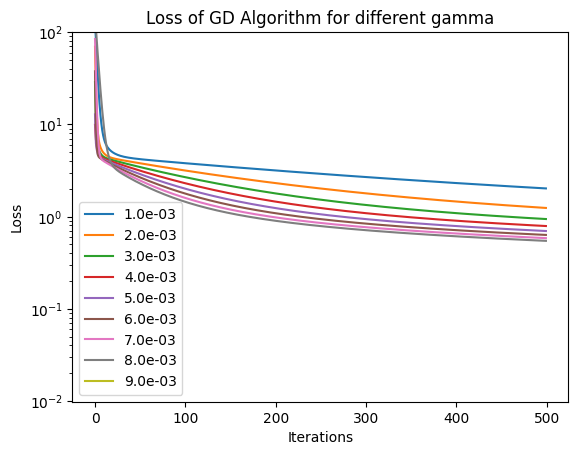

In [90]:
gamma = np.arange(0.001, 0.010, 0.001)
g_opti = gamma[0]
loss_opti = 1000
f1_opti = 0

ax = plt.axes()

#Loop on the different values of gamma
for g in gamma:
    weights, loss = f.mean_squared_error_gd(y_train_train_reduced, tX_train_train_reduced, initial_w, 500, g)
    print("%.1e: %.4f" % (g, loss[-1]))

    ax.semilogy(loss, label = "%.1e" % g)

    y_pred = tX_train_validation.dot(weights[-1,:])
    y_pred = np.where(y_pred > 0, 1, -1)

    _,_,_,_,f1 = f.confusion_matrix(y_train_validation, y_pred)


    if f1 > f1_opti:
        loss_opti = loss[-1]
        g_opti = g
        f1_opti = f1
    print("F1 score: %.6f \n" % f1)


print("optimal gamma: %.2e, F1-score =  %.6f, Loss = %.3f " % (g_opti, f1_opti, loss_opti))
ax.set_ylim([0, 100])
plt.title("Loss of GD Algorithm for different gamma")
plt.xlabel("Iterations")
plt.ylabel("Loss")


plt.legend()
plt.show()

No matter the number of iterations, the value of the learning rate matters quite a lot.

The weights are saved at each iterations, and applied on the validation set, in order to see the rate of improvement on the validation set with respect to the training one. 

In [91]:
#Compute gradient descent with MSE as loss function (see functions.py for the function)
w_mse_gd_gamma1, loss_mse_gd_gamma1 = f.mean_squared_error_gd(y_train_train_reduced, tX_train_train_reduced, initial_w, 2000, 0.0078)
w_mse_gd_gamma2, loss_mse_gd_gamma2 = f.mean_squared_error_gd(y_train_train_reduced, tX_train_train_reduced, initial_w, 2000, 0.007)
w_mse_gd_gamma3, loss_mse_gd_gamma3 = f.mean_squared_error_gd(y_train_train_reduced, tX_train_train_reduced, initial_w, 15000, 0.00001)


Gradient Descent(2000/2000): Final loss=0.32872807616118205
Gradient Descent(2000/2000): Final loss=0.33538128661888367
Gradient Descent(15000/15000): Final loss=3.4594371089755906


In [92]:
#Compute the loss on the validation set for the different gamma values, takes a long time to run

loss_test_set_1 = []
for w in w_mse_gd_gamma1:
    loss_test_set_1.append(f.compute_mse(y_train_validation, tX_train_validation, w))

final_loss_test_1 = loss_test_set_1[-1]

loss_test_set_2 = []
for w in w_mse_gd_gamma2:
    loss_test_set_2.append(f.compute_mse(y_train_validation, tX_train_validation, w))
final_loss_test_2 = loss_test_set_2[-1]

loss_test_set_3 = []
for w in w_mse_gd_gamma3:
    loss_test_set_3.append(f.compute_mse(y_train_validation, tX_train_validation, w))
final_loss_test_3 = loss_test_set_3[-1]

print(final_loss_test_1,final_loss_test_2, final_loss_test_3)


0.2553708189867459 0.26190209568892475 3.156354576664145


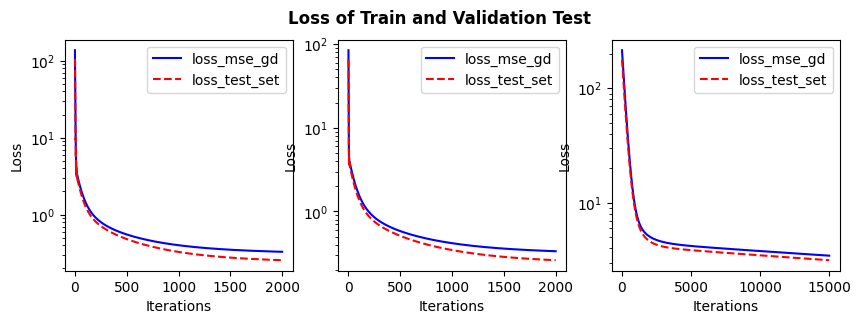

In [93]:
#Plot of the improvement in function of the number of iterations
loss_mse_gd = [loss_mse_gd_gamma1,loss_mse_gd_gamma2,loss_mse_gd_gamma3]
loss_test_set = [loss_test_set_1,loss_test_set_2,loss_test_set_3]

fig, axs = plt.subplots(1, 3, figsize=(10, 3))

# Plotting the loss for training and test set on each subplot
for i in range(3):
    axs[i].semilogy(loss_mse_gd[i], '-b', label='loss_mse_gd')
    axs[i].semilogy(loss_test_set[i], '--r', label='loss_test_set')
    axs[i].legend(frameon=True)
    axs[i].set_xlabel('Iterations')
    axs[i].set_ylabel('Loss')

# Adding a title to the entire figure
fig.suptitle('Loss of Train and Validation Test', fontweight='bold')

plt.show()

The gradient descent is then computed with the optimal learning rate. The plot serves as visual indicator to assess whether or not there's overfitting with the increasing number of iterations.

In [94]:
weights_mse_gd, loss_mse_gd = f.mean_squared_error_gd(y_train_train_reduced, tX_train_train_reduced, initial_w, 10000, g_opti)

Gradient Descent(10000/10000): Final loss=0.3032781180749511


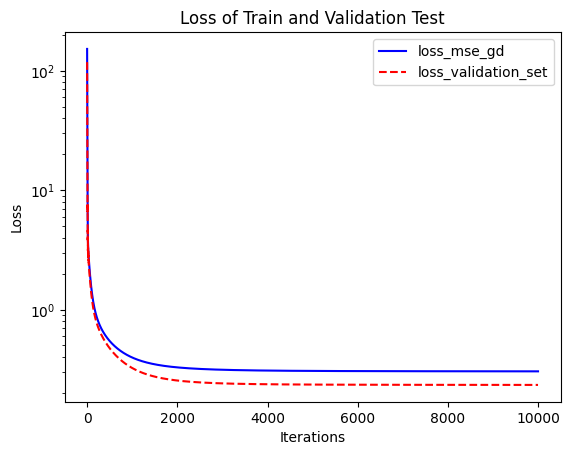

In [95]:
loss_validation_set = []
for w in weights_mse_gd:
    loss_validation_set.append(f.compute_mse(y_train_validation, tX_train_validation, w))

ax = plt.axes()

plt.semilogy(loss_mse_gd, '-b', label='loss_mse_gd')
plt.semilogy(loss_validation_set, '--r', label='loss_validation_set')
plt.legend(frameon=True)
plt.title('Loss of Train and Validation Test')
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')
plt.show()

It's quite surprising that the loss on the validation set is higher than the loss on the training set. We would have expected the opposite. This is probably due to the fact that we have a small training set, in order to equilibrate the labels.

We compute precision and accuracy metrics on the validation set we created.

In [96]:
y_pred = tX_train_validation.dot(weights_mse_gd[-1, :])
y_pred = np.where(y_pred > 0, 1, -1)

_,_,_,_,f1 = f.confusion_matrix(y_train_validation, y_pred)

print("Accuracy: ", np.sum(y_pred == y_train_validation)/len(y_train_validation))
print("F1 score: ", f1)


Accuracy:  0.8469032212188011
F1 score:  0.4017307768647533


We apply the model to the test sample

In [97]:
y_test = tX_test.dot(weights_mse_gd[-1, :])
y_test_rounded = np.where(y_test > 0, 1, -1) 

print('weights = \n\n', weights_mse_gd[-1, :],'\n\n Loss = ', loss_mse_gd,'\n\n*****************************************************************************',
      ' \n\n Train sample : \n', 'Heart attack rate = ', np.count_nonzero(y_train == 1)/len(y_train), '\n \n Test sample : \n', 'Heart attack rate = ', np.count_nonzero(y_test_rounded == 1)/len(y_test_rounded))

weights = 

 [ 6.32225858e-01  1.20892743e-01  2.10016939e-03 -3.06224578e-04
 -8.42990227e-02 -7.21039798e-02 -2.26356516e-01 -4.81274383e-01
 -1.04849873e-01 -2.40126558e-01 -3.16292629e-02 -1.90337863e-02
 -2.07157529e-01 -1.05120849e-01 -2.13331598e-01  9.40798986e-02
  4.93498460e-02 -8.22316456e-01 -5.20701233e-02 -1.59022008e-02
 -9.06934447e-03 -2.89186250e-02] 

 Loss =  [152.71497255 109.86082749  79.71271217 ...   0.30327849   0.30327831
   0.30327812] 

*****************************************************************************  

 Train sample : 
 Heart attack rate =  0.08830207079403295 
 
 Test sample : 
 Heart attack rate =  0.16711617403706377


In [128]:
h.create_csv_submission(test_ids, y_test_rounded, 'submission_gd.csv')

### 2. MSE SGD

Similarly to the gradient descent, we try different values of gamma for gradient descent with MSE as loss function. 

As the results are quite random (Cf. graph below), the assessment of the optimal learning rate is based on the average of the past 100 losses values (arbitrarily chosen).

SGD iter. 999/999: loss=0.35658887323465016
5.0e-04

SGD iter. 999/999: loss=0.8132441696688233
6.7e-04

SGD iter. 999/999: loss=1.1813397395678216
8.3e-04

SGD iter. 999/999: loss=0.8019789607111175
1.0e-03

SGD iter. 999/999: loss=0.744178885602296
1.2e-03

SGD iter. 999/999: loss=0.3343156214718942
1.3e-03

SGD iter. 999/999: loss=1.817681478158938
1.5e-03

SGD iter. 999/999: loss=0.30974795131242777
1.7e-03

SGD iter. 999/999: loss=0.15733804637007665
1.8e-03

SGD iter. 999/999: loss=0.19585678932114564
2.0e-03

Optimal gamma: 1.00e-03, F1-score =  0.263467, Loss = 0.675 


C:\Users\broth\AppData\Local\Temp\ipykernel_18540\47240353.py:20: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim([0, 100])


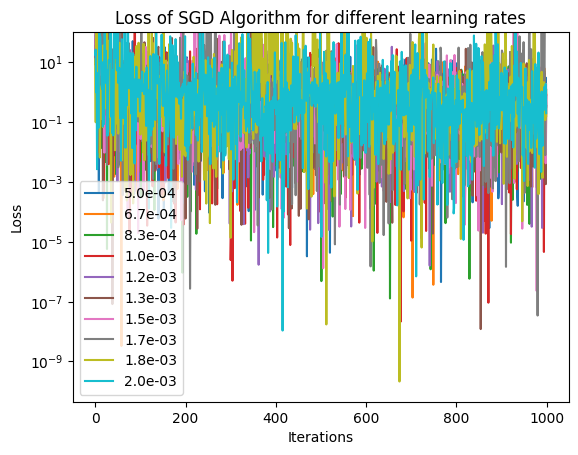

In [99]:
gamma = np.linspace(0.0005, 0.0020, 10)
#gamma = [0.0001, 0.001, 0.01, 0.1]

g_opti = gamma[0]
loss_opti = 1000

ax = plt.axes()
for g in gamma:
    weights, loss = f.mean_squared_error_sgd(y_train_train_reduced, tX_train_train_reduced, initial_w, 1000, g)
    mean_loss = np.mean(loss[-100:])
    if mean_loss < loss_opti:
        loss_opti = mean_loss
        g_opti = g
    print("%.1e\n" % (g))
    ax.semilogy(loss, label = "%.1e" % g)


print("Optimal gamma: %.2e, F1-score =  %.6f, Loss = %.3f " % (g_opti, f1_opti, loss_opti))

ax.set_ylim([0, 100])
plt.title("Loss of SGD Algorithm for different learning rates")
plt.xlabel("Iterations")
plt.ylabel("Loss")

plt.legend()
plt.show()


The values are highly variable due to the stochasticity of the algorithm. 

In [100]:
w_mse_sgd, loss_mse_sgd = f.mean_squared_error_sgd(y_train_train_reduced, tX_train_train_reduced, initial_w, 10000, g_opti)

SGD iter. 9999/9999: loss=0.07193682218592044


Text(0, 0.5, 'Loss')

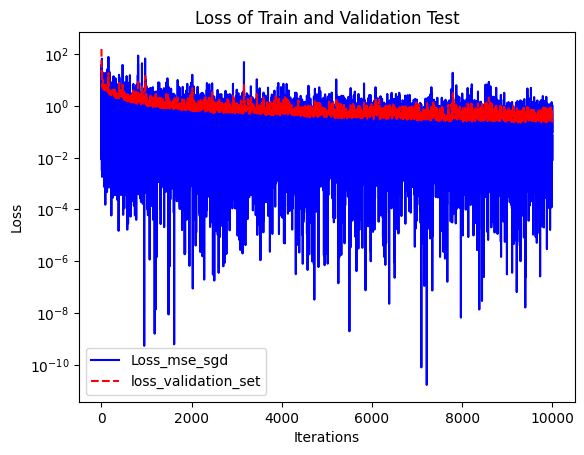

In [101]:
loss_validation_set = []
for w in w_mse_sgd:
    loss_validation_set.append(f.compute_mse(y_train_validation, tX_train_validation, w))

ax = plt.axes()
plt.title('Loss of Train and Validation Test')
plt.semilogy(loss_mse_sgd, '-b', label='Loss_mse_sgd')
plt.semilogy(loss_validation_set, '--r', label='loss_validation_set')
plt.legend(frameon=True)
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')

There's no sign of overfitting, the loss on the validation set is decreasing with the number of iterations.

In [102]:
y_pred = tX_train_validation.dot(w_mse_sgd[-1])
y_pred = np.where(y_pred > 0, 1, -1)

_,_,_,_,f1 = f.confusion_matrix(y_train_validation, y_pred)

print("Accuracy: ", np.sum(y_pred == y_train_validation)/len(y_train_validation))

print("F1 score: ", f1)

Accuracy:  0.8766164504627137
F1 score:  0.3081567555251766


On the test set, this is the ratio we obtain. We can see that the ratio is quite close to the one we have on the train set.

In [131]:
y_test_sgd = tX_test.dot(w_mse_sgd[-1])
y_test_rounded_sgd = np.where(y_test_sgd > 0, 1, -1)

print('weights = \n', w_mse_sgd[-1],'\n Loss = ', loss_mse_sgd[-1],'\n*****************************************************************************',
      ' \n Train sample : \n', 'Heart attack rate = ', np.count_nonzero(y_train == 1)/len(y_train), '\n \n Test sample : \n', 'Heart attack rate = ', np.count_nonzero(y_test_rounded_sgd == 1)/len(y_test_rounded_sgd))

weights = 
 [ 0.98392115  0.1239051   0.01480191 -0.01991359  0.48490904  0.43396118
 -0.44169128 -0.79935675 -0.14628333 -0.23428794 -0.03902379 -0.03732867
  0.09392503 -0.18883349 -0.05100518 -0.24780838  0.0570259  -0.8747952
 -0.62172245 -0.2316296   0.29816617 -0.19034885] 
 Loss =  0.07193682218592044 
*****************************************************************************  
 Train sample : 
 Heart attack rate =  0.08830207079403295 
 
 Test sample : 
 Heart attack rate =  0.089697291070498


### 3. Least squares

Least squares method is straight-forward. We apply the algorithm without adding any parameters.

For this algorithm, we try different ratios of data in the training dataset to observe whether or not it leads to some improvement. 

In [104]:

splits = np.linspace(1,4,4)
weights = []
losses = []
s_opti = splits[0]
f1_opti = 0
for s in splits: 
    #Similar to the initial split reduction of data seen above
    tX_train_neg_red = tX_train_neg[:int(len(tX_train_pos)*s),:]
    y_train_neg_red = y_train_neg[:int(len(tX_train_pos)*s)]

    tX_train_train_reduced = np.concatenate((tX_train_neg_red, tX_train_pos))
    y_train_train_reduced = np.concatenate((y_train_neg_red, y_train_pos))

    w_ls, loss_ls = f.least_squares(y_train_train_reduced, tX_train_train_reduced)

    weights.append(w_ls)
    losses.append(loss_ls)
    print(f"Split at %.1f/%.1f %%, loss = %.4f" %((s/(s+1)*100), 1/(s+1)*100, loss_ls))
    y_pred = tX_train_validation.dot(w_ls)
    y_pred = np.where(y_pred > 0, 1, -1)

    _,_,_,_,f1 = f.confusion_matrix(y_train_validation, y_pred)
    if f1 > f1_opti:
        f1_opti = f1
        s_opti = s

    print("Accuracy: ", np.sum(y_pred == y_train_validation)/len(y_train_validation))

    print("F1 score: ", f1)


Split at 50.0/50.0 %, loss = 0.3203
Accuracy:  0.7423532877561179
F1 score:  0.35810998911750563
Split at 66.7/33.3 %, loss = 0.3007
Accuracy:  0.8475838319399437
F1 score:  0.4068627450980392
Split at 75.0/25.0 %, loss = 0.2684
Accuracy:  0.8869475117075203
F1 score:  0.38814668206058606
Split at 80.0/20.0 %, loss = 0.2391
Accuracy:  0.9032009020631647
F1 score:  0.3275703902335756


It seems the optimal split is the ratio comprising twice the amount of data with heart disease than without. We will use this ratio for the other methods aswell.

In [105]:
tX_train_neg_red = tX_train_neg[:int(len(tX_train_pos)*s_opti),:]
y_train_neg_red = y_train_neg[:int(len(tX_train_pos)*s_opti)]

tX_train_train_reduced = np.concatenate((tX_train_neg_red, tX_train_pos))
y_train_train_reduced = np.concatenate((y_train_neg_red, y_train_pos))

In [106]:
w_ls, loss_ls = f.least_squares(y_train_train_reduced, tX_train_train_reduced)

In [107]:
y_pred = tX_train_validation.dot(w_ls)
y_pred = np.where(y_pred > 0, 1, -1)

print(f"Loss: ", loss_ls)

_,_,_,_,f1 = f.confusion_matrix(y_train_validation, y_pred)

print("Accuracy: ", np.sum(y_pred == y_train_validation)/len(y_train_validation))

print("F1 score: ", f1)

Loss:  0.30074124873607244
Accuracy:  0.8475838319399437
F1 score:  0.4068627450980392


In [108]:

y_test_ls = tX_test.dot(w_ls)
y_test_ls = np.where(y_test_ls > 0, 1, -1)

print('weights = \n', w_ls,'\n Loss = ', loss_ls,'\n*****************************************************************************',
      ' \n Train sample : \n', 'Heart attack rate = ', np.count_nonzero(y_train == 1)/len(y_train), '\n \n Test sample : \n', 'Heart attack rate = ', np.count_nonzero(y_test_ls == 1)/len(y_test_ls))

weights = 
 [-0.08327563  0.14537865  0.00223654  0.00044005 -0.06180804 -0.03361978
 -0.22164132 -0.42265745 -0.07863368 -0.22883214 -0.00890023 -0.01572196
 -0.16091321 -0.10390355 -0.19235511  0.12462448  0.0546625  -0.33881248
  0.06115368 -0.0064018  -0.00522325 -0.01217399] 
 Loss =  0.30074124873607244 
*****************************************************************************  
 Train sample : 
 Heart attack rate =  0.08830207079403295 
 
 Test sample : 
 Heart attack rate =  0.16729902449281855


In [109]:
h.create_csv_submission(test_ids, y_test_ls, 'submission_ls.csv')

### 4. Ridge regression


The ridge regression differs from the least squares as we apply a penalty to the complexification of the weights (increase in values). We try to identify which should be the optimal weight we attribute to this penalty.

The same data balance is applied.

In [110]:
#Try different values of gamma for gradient descent with MSE as loss function
gamma = [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 1]
#gamma = np.linspace(1*10**(-7),1*10**-2 , 8)
l_opti = lambda[0]
loss_opti = 1000
f1_opti = 0
for l in lambda:
    w_ridge, loss_ridge = f.ridge_regression(y_train_train_reduced, tX_train_train_reduced, l)
    print("%.2e: %f" % (l, loss_ridge))


    y_pred = tX_train_validation.dot(w_ridge)
    y_pred = np.where(y_pred > 0, 1, -1)
    _,_,_,_,f1 = f.confusion_matrix(y_train_validation, y_pred)

    if f1 > f1_opti:
        loss_opti = loss_ridge
        l_opti = l
        f1_opti = f1
    print("F1 score: %.6f \n" % f1)

print("optimal lambda: %.e " % l_opti)


1.00e-07: 0.300741
F1 score: 0.406863 

1.00e-06: 0.300741
F1 score: 0.406863 

1.00e-05: 0.300741
F1 score: 0.407005 

1.00e-04: 0.300742
F1 score: 0.407210 

1.00e-03: 0.300770
F1 score: 0.407178 

1.00e-02: 0.301292
F1 score: 0.405410 

1.00e+00: 0.343422
F1 score: 0.329240 

optimal gamma: 1e-04 


The optimal weight to attribute to the malus seems to be 0.0001, as it gives the best F1 score on the validation set. We will the used this value in the training of the model

In [111]:
w_ridge, loss_ridge = f.ridge_regression(y_train_train_reduced, tX_train_train_reduced, g_opti)

The accuracy and the F1-score computed on the validation set are show below. 

In [127]:
y_pred = tX_train_validation.dot(w_ridge)
y_pred = np.where(y_pred > 0, 1, -1)

print(f"Loss: ", loss_ridge)
_,_,_,_,f1 = f.confusion_matrix(y_train_validation, y_pred)

print("Accuracy: ", np.sum(y_pred == y_train_validation)/len(y_train_validation))

print("F1 score: ", f1)

Loss:  0.30074180369568726
Accuracy:  0.8476549405227497
F1 score:  0.4072097711371991


Test set label attributions

In [113]:
y_test_ridge = tX_test.dot(w_ridge)
y_test_ridge = np.where(y_test_ridge > 0, 1, -1)

print('weights = \n', w_ridge,'\n Loss = ', loss_ridge,'\n*****************************************************************************',
      ' \n Train sample : \n', 'Heart attack rate = ', np.count_nonzero(y_train == 1)/len(y_train), '\n \n Test sample : \n', 'Heart attack rate = ', np.count_nonzero(y_test_ridge == 1)/len(y_test_ridge))

weights = 
 [-0.08769108  0.14523005  0.00224687  0.00043884 -0.0618429  -0.03363197
 -0.22147051 -0.42183348 -0.07853322 -0.22861652 -0.00896958 -0.01575225
 -0.16060205 -0.10393922 -0.19204503  0.12407215  0.05472466 -0.32250502
  0.06034555 -0.00650184 -0.00522239 -0.01233579] 
 Loss =  0.30074180369568726 
*****************************************************************************  
 Train sample : 
 Heart attack rate =  0.08830207079403295 
 
 Test sample : 
 Heart attack rate =  0.1673355945839695


In [114]:
h.create_csv_submission(test_ids, y_test_ridge, 'submission_ridge.csv')

### 5. Logistic regression

For the logistic regression, the datas are processed once again as the -1 needs to be transformed to 0. 

In [115]:
#Transformation of the label, so taht we can use the logistic regression function
y_train_train_red_lg = np.where(y_train_train_reduced == 1, 1, 0)
y_train_validation_lg = np.where(y_train_validation == 1, 1, 0)
initial_w = [random.choice([1, 0]) for i in range(len(tX_train[0]))]
#transform initial_w as an array
initial_w = np.array(initial_w)

Then, we try different values of gamma on a small number of iteration in order to extract the optimal one 

Gradient Descent(1999/1999): loss=0.48594405585886485, w0=0.604789746813082, w1=0.1795409682787704
1.00e-02, loss = 0.486
F1 score: 0.349648 

Gradient Descent(1999/1999): loss=0.46037586241038525, w0=0.4868396424199131, w1=0.272969793434739
2.00e-02, loss = 0.460
F1 score: 0.379939 

Gradient Descent(1999/1999): loss=0.4540097709934304, w0=0.4047016021414943, w1=0.32182303335350265
3.00e-02, loss = 0.454
F1 score: 0.389395 

Gradient Descent(1999/1999): loss=0.4516261626129697, w0=0.338179271786938, w1=0.3493959442444445
4.00e-02, loss = 0.452
F1 score: 0.394382 

Gradient Descent(1999/1999): loss=0.4504577808270497, w0=0.2811564483408193, w1=0.3657304104544976
5.00e-02, loss = 0.450
F1 score: 0.395791 

Gradient Descent(1999/1999): loss=0.5261192905243341, w0=0.2552406098181267, w1=0.44590213821280955
6.00e-02, loss = 0.526
F1 score: 0.379850 

Gradient Descent(1999/1999): loss=0.5774657484406149, w0=0.213557034426349, w1=0.49630421244949985
7.00e-02, loss = 0.577
F1 score: 0.240219 

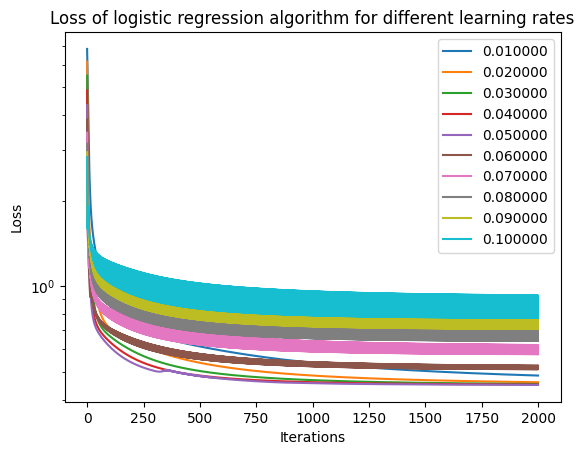

In [116]:
#Try different values of gamma for gradient descent with MSE as loss function

gamma = np.linspace(1*10**(-2), 1*10**(-1), 10)
g_opti = gamma[0]
loss_opti = 1000
f1_opti = 0
for g in gamma:
    w_logreg, loss_logreg = f.logistic_regression(y_train_train_red_lg, tX_train_train_reduced, initial_w, 2000, g)
    print("%.2e, loss = %.3f" % (g, loss_logreg[-1]))
    plt.semilogy(loss_logreg, label = "%f" % g)

    y_pred = tX_train_validation.dot(w_logreg[-1])
    y_pred = np.where(y_pred > 0.5, 1, 0)
    y_pred = np.where(y_pred == 1, 1, -1)

    _,_,_,_,f1 = f.confusion_matrix(y_train_validation, y_pred)

    
    if f1 > f1_opti:
        loss_opti = loss_logreg[-1]
        g_opti = g
        f1_opti = f1
    print("F1 score: %.6f \n" % f1)


print("Optimal gamma: %e, F1-score =  %.6f, Loss = %.3f " % (g_opti, f1_opti, loss_opti))
plt.title("Loss of logistic regression algorithm for different learning rates")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

The best learning rate is 0.05, as it gives the best F1-score on the validation test set. The F1-score has been chosen as the main criterium of validation given the distribution of the data, heavily unbalanced. 
We can also observe that it is not necessarily the lowest lost between all of the trials. 

In [117]:
n_iter = 5000
w_logreg, loss_logreg = f.logistic_regression(y_train_train_red_lg, tX_train_train_reduced,initial_w, n_iter, g_opti)

Gradient Descent(4999/4999): loss=0.4480876961563442, w0=-0.05718250475303758, w1=0.40278550519855627


Text(0, 0.5, 'Loss')

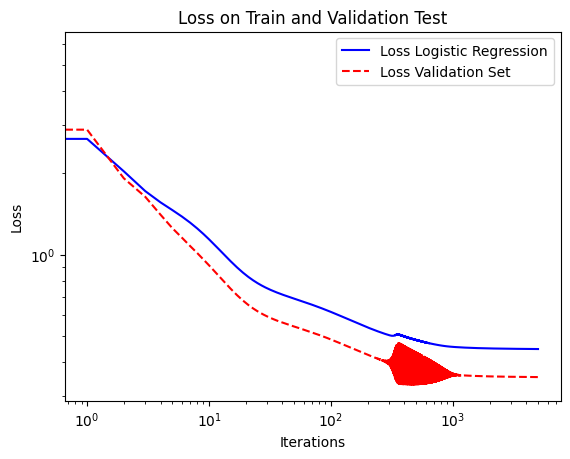

In [118]:
loss_validation_set = np.zeros(n_iter)
k = 0
for i, w in enumerate(w_logreg):
    loss_validation_set[i] = f.compute_loss_logistic(y_train_validation_lg, tX_train_validation, w)
 

ax = plt.axes()

ax.set_xscale('log')

plt.semilogy(loss_logreg, '-b', label='Loss Logistic Regression')
plt.semilogy(loss_validation_set, '--r', label='Loss Validation Set')
plt.legend(frameon=True)
plt.title('Loss on Train and Validation Test')
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')

It is surprising that the loss on the validation set is smaller than the one on the training set, we observe a stabilization at the end of the iterations, which means that the algorithm has converged.

We also observe a weird behaviour after a few hundred iterations which then stabilizes. 


Finally, we compute the validation metrics and the predictions on the test set-

In [119]:
y_pred = tX_train_validation.dot(w_logreg[-1])
y_pred = np.where(y_pred > 0.5, 1, 0)
y_pred = np.where(y_pred == 1, 1, -1)

_,_,_,_,f1 = f.confusion_matrix(y_train_validation, y_pred)

print("Accuracy: ", np.sum(y_pred == y_train_validation)/len(y_train_validation))

print("F1 score: ", f1)

Accuracy:  0.8810556577035991
F1 score:  0.39802580844172536


In [120]:
y_test_logreg = tX_test.dot(w_logreg[-1, :])
y_test_logreg = np.where(y_test_logreg > 0.5, 1, 0)

print('weights = \n', w_logreg[-1,:],'\n Loss = ', loss_logreg[-1],'\n*****************************************************************************',
        ' \n Train sample : \n', 'Heart attack rate = ', np.count_nonzero(y_train== 1)/len(y_train), '\n \n Test sample : \n', 'Heart attack rate = ', np.count_nonzero(y_test_logreg == 1)/len(y_test_logreg))

weights = 
 [-0.0571825   0.40278551  0.00387859  0.00227839 -0.26576957 -0.2955851
 -0.69661867 -1.27129598 -0.20547339 -0.80651682 -0.08979783 -0.06054144
 -0.42042383 -0.37817392 -0.61023435  0.40511832  0.21516366  0.54676135
 -0.26168534 -0.05425834 -0.04166877 -0.0833479 ] 
 Loss =  0.4480876961563442 
*****************************************************************************  
 Train sample : 
 Heart attack rate =  0.08830207079403295 
 
 Test sample : 
 Heart attack rate =  0.10796405160039861


In [129]:
y_sub = np.where(y_test_logreg == 1, 1, -1)
h.create_csv_submission(test_ids, y_sub, 'submission_logreg.csv')

### 6. Regularized logistic regression

This algorithm contains 2 values to optimize, the learning rate and the weight to attribute the penalty attributed to the increase in the value of the weights. 

Gradient Descent(999/999): loss=6.8177287434156915, w0=0.9933440186891109, w1=-0.016394055806938958
gamma = 1.00e-05, lambda = 1.00e-05, loss = 0.448
F1 score: 0.163553 

Gradient Descent(999/999): loss=6.8177223167169005, w0=0.9933431217076886, w1=-0.016394048336671713
gamma = 1.00e-05, lambda = 1.00e-04, loss = 0.448
F1 score: 0.163553 

Gradient Descent(999/999): loss=6.817658050054062, w0=0.9933341519378851, w1=-0.016393973634232104
gamma = 1.00e-05, lambda = 1.00e-03, loss = 0.448
F1 score: 0.163553 

Gradient Descent(999/999): loss=6.817015415929467, w0=0.9932444586806582, w1=-0.0163932266331116
gamma = 1.00e-05, lambda = 1.00e-02, loss = 0.448
F1 score: 0.163553 

Gradient Descent(999/999): loss=6.810592324003623, w0=0.9923479700408164, w1=-0.01638575894878898
gamma = 1.00e-05, lambda = 1.00e-01, loss = 0.448
F1 score: 0.163553 

Gradient Descent(999/999): loss=2.756300412243702, w0=0.9424346795331136, w1=-0.1293418992648027
gamma = 1.00e-04, lambda = 1.00e-05, loss = 0.448
F1 s

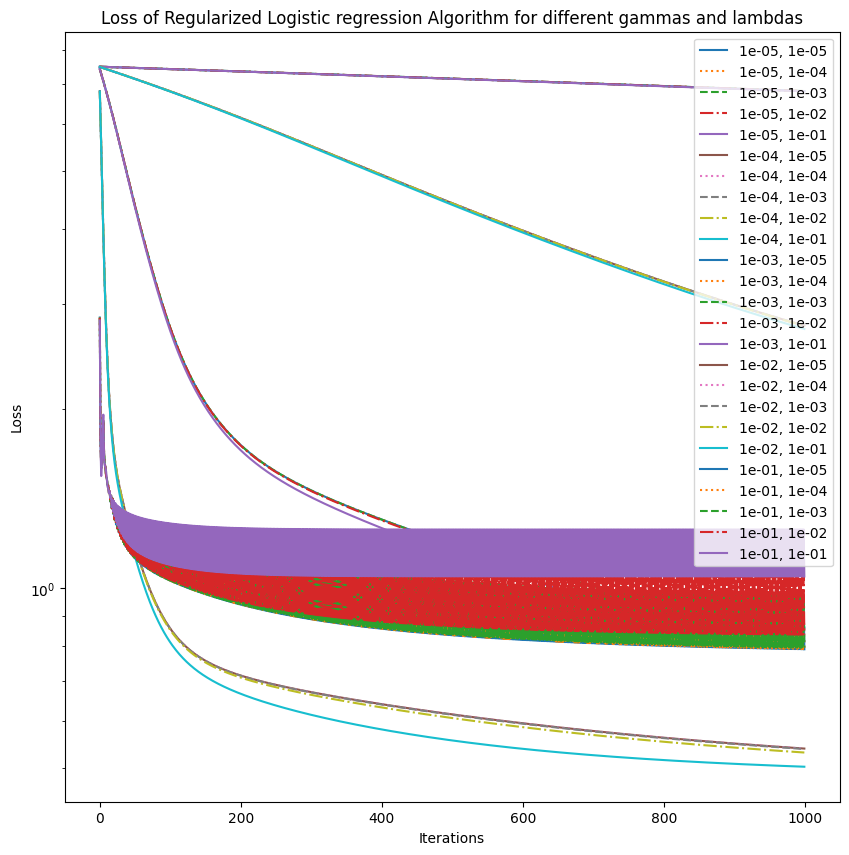

In [122]:
# 2 loops combined to try different values of each of the parameters
plt.figure(figsize = (10,10))
gamma = [0.00001, 0.0001, 0.001, 0.01, 0.1]
lambdas = [0.00001, 0.0001, 0.001, 0.01, 0.1]
g_opti = gamma[0]
l_opti = lambdas[0]
loss_opti = 1000
f1_opti = 0

linestyles = ['solid', 'dotted', 'dashed', 'dashdot', 'solid']
for g in gamma:
    for i, l in enumerate(lambdas):

        w_reg_logreg, loss_reg_logreg = f.reg_logistic_regression(y_train_train_red_lg, tX_train_train_reduced, l, initial_w, 1000, g)
        print("gamma = %.2e, lambda = %.2e, loss = %.3f" % (g, l, loss_logreg[-1]))
        y_pred = tX_train_validation.dot(w_reg_logreg[-1])
        y_pred = np.where(y_pred > 0.5, 1, 0)
        y_pred = np.where(y_pred == 1, 1, -1)

        _,_,_,_,f1 = f.confusion_matrix(y_train_validation, y_pred)

        
        if f1 > f1_opti:
            loss_opti = loss_reg_logreg[-1]
            g_opti = g
            l_opti = l
            f1_opti = f1
        print("F1 score: %.6f \n" % f1)
        plt.semilogy(loss_reg_logreg, label = "%.0e, %.0e" % (g, l), linestyle = linestyles[i]  )

s

print("Optimal gamma: %e, optimal lambda : %e, F1-score =  %.6f, Loss = %.3f " % (g_opti, l_opti, f1_opti, loss_opti))
plt.title("Loss of Regularized Logistic regression Algorithm for different gammas and lambdas")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

The best set of parameters seems to be gamma = 1.00e-01, lambda = 1.00e-01. Once again, it is not necessarily the one with the lowest loss on the training set. In this case, it actually is the one with the highest variance with the thick purple and red lines in the middle. 
This is due to the fact that the loss on the training set is not necessarily a good indicator of the performance of the algorithm on the test set. This is why we use the validation set to tune the parameters.

In [123]:
w_reg_logreg, loss_reg_logreg = f.reg_logistic_regression(y_train_train_red_lg, tX_train_train_reduced, l_opti, initial_w, 6000, g_opti)

Gradient Descent(5999/5999): loss=0.48009329432429426, w0=-0.09110226909101099, w1=0.1908434078515386


In [124]:
y_pred = tX_train_validation.dot(w_reg_logreg[-1])
y_pred = np.where(y_pred > 0.5, 1, 0)
y_pred = np.where(y_pred == 1, 1, -1)

_,_,_,_,f1 = f.confusion_matrix(y_train_validation, y_pred)

print("Accuracy: ", np.sum(y_pred == y_train_validation)/len(y_train_validation))

print("F1 score: ", f1)

Accuracy:  0.8888572850743085
F1 score:  0.3265004616805171


The results are worse than with the logistic regression without regularization, which is quite suprising, as it should give atleast the same results with a very low weight for the regularization term.

Finaly, we apply the trained algorithm on the test set. 

In [125]:
y_test_reg_logreg = tX_test.dot(w_reg_logreg[-1])
y_test_reg_logreg = np.where(y_test_reg_logreg > 0.5, 1, 0)

print('weights = \n', w_reg_logreg[-1],'\n Loss = ', loss_reg_logreg[-1],'\n*****************************************************************************',
        ' \n Train sample : \n', 'Heart attack rate = ', np.count_nonzero(y_train == 1)/len(y_train), '\n \n Test sample : \n', 'Heart attack rate = ', np.count_nonzero(y_test_reg_logreg == 1)/len(y_test_reg_logreg))


weights = 
 [-0.09110227  0.19084341  0.01915943  0.00081004 -0.04452036 -0.0784263
 -0.26340792 -0.21757201 -0.24404987 -0.25389566 -0.17988023 -0.11105182
 -0.17146872 -0.16829086 -0.2738217   0.02816406  0.17307689 -0.01949276
 -0.07251026 -0.02220739 -0.0154568  -0.0158325 ] 
 Loss =  0.48009329432429426 
*****************************************************************************  
 Train sample : 
 Heart attack rate =  0.08830207079403295 
 
 Test sample : 
 Heart attack rate =  0.07493211676830104


In [126]:
y_sub = np.where(y_test_reg_logreg == 1, 1, -1)
h.create_csv_submission(test_ids, y_sub, 'submission_reg_logreg.csv')